## Testing best-of-n sampling

In [3]:
import re
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
import sys
sys.path.append("..")


import torch
from transformers import AutoTokenizer
from vllm import LLM, SamplingParams
from tqdm.notebook import tqdm

from prover.lean.verifier import Lean4ServerScheduler
import pickle

import numpy as np
import matplotlib.pyplot as plt


# Set RC params for consistent styling
plt.rcParams.update({
    'font.size': 12,  # Base font size
    #'axes.titlesize': 14,  # Title font size
    'axes.labelsize': 12,  # Label font size
    'xtick.labelsize': 12,  # X-tick label size
    'ytick.labelsize': 12,  # Y-tick label size
    'legend.fontsize': 10,  # Legend font size
    'figure.titlesize': 12,  # Figure title size
})

In [154]:
!gpustat

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


rnn.ist.berkeley.edu  Mon Jan 27 23:24:15 2025  535.104.12
[0] NVIDIA RTX A6000 | 66'C,  99 % | 38688 / 49140 MB | evanellis(37786M)
[1] NVIDIA RTX A6000 | 73'C,  99 % | 38618 / 49140 MB | evanellis(37826M)
[2] NVIDIA RTX A6000 | 73'C, 100 % | 44648 / 49140 MB | micah(44168M)
[3] NVIDIA RTX A6000 | 30'C,   0 % | 44262 / 49140 MB |
[4] NVIDIA RTX A6000 | 31'C,   0 % | 44828 / 49140 MB | lukebailey(44342M)
[5] NVIDIA RTX A6000 | 74'C,  98 % | 44652 / 49140 MB | micah(44172M)
[6] NVIDIA RTX A6000 | 70'C, 100 % | 38682 / 49140 MB | evanellis(37826M)
[7] NVIDIA RTX A6000 | 77'C, 100 % | 38757 / 49140 MB | ebronstein(28M) evanellis(37826M)


In [4]:
model_name = "../../models/deepseek-prover-RL"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = LLM(model=model_name, max_num_batched_tokens=8192, seed=1, trust_remote_code=True, dtype="auto", device="cuda")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 01-27 15:20:35 llm_engine.py:98] Initializing an LLM engine (v0.4.1) with config: model='../../models/deepseek-prover-RL', speculative_config=None, tokenizer='../../models/deepseek-prover-RL', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), seed=1)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 01-27 15:20:35 utils.py:608] Found nccl from library /home/lukebailey/.config/vllm/nccl/cu12/libnccl.so.2.18.1
INFO 01-27 15:20:36 selector.py:77] Cannot use FlashAttention backend because the flash_attn package is not found. Please install it for better performance.
INFO 01-27 15:20:36 selector.py:33] Using XFormers backend.
INFO 01-27 15:20:39 model_runner.py:173] Loading model weights took 12.8725 GB
INFO 01-27 15:20:41 gpu_executor.py:119] # GPU blocks: 3858, # CPU blocks: 546
INFO 01-27 15:20:43 model_runner.py:976] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 01-27 15:20:43 model_runner.py:980] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory

In [5]:
import json

# Load the dataset
with open("/nas/ucb/lukebailey/DeepSeek-Prover-V1.5/datasets/imo_minif2f_data.jsonl", "r") as f:
    imo_data = [json.loads(line) for line in f]

with open("/nas/ucb/lukebailey/DeepSeek-Prover-V1.5/datasets/math_minif2f_data.jsonl", "r") as f:
    math_data = [json.loads(line) for line in f]

In [155]:
def get_best_of_n(dataset, n, batch_size, model, save=False):


    sampling_params = SamplingParams(
        temperature=1.0,
        max_tokens=2048,
        top_p=0.95,
        n=1,
    )

    #model_outputs = model.generate(
    #    model_inputs,
    #    sampling_params,
    #    use_tqdm=False,
    #)
    #result = prompt + code_prefix + model_outputs[0].outputs[0].text
    #print(result)

    prompt = r'''Complete the following Lean 4 code:

```lean4
'''

    num_examples = len(dataset)

    all_samples = []
    for i in tqdm(range(0, num_examples, batch_size), desc="Processing batches", position=0):
        batch = dataset[i:i+batch_size]
        batch = [prompt + x["header"] + x["informal_prefix"] + x["formal_statement"] for x in batch]
        actual_batch_size = len(batch)

        current_batch_samples = [[] for _ in range(actual_batch_size)]

        for j in tqdm(range(n), desc="Generating samples", leave=False, position=1):

            model_outputs = model.generate(
                batch,
                sampling_params,
                use_tqdm=False,
            )

            result = [input_ + output.outputs[0].text for input_, output in zip(batch, model_outputs)]
            assert len(result) == actual_batch_size
            for k in range(actual_batch_size):
                current_batch_samples[k].append(result[k])
        
        all_samples.extend(current_batch_samples)


        if save:
            with open("best_of_n_samples_imo.pkl", "wb") as f:
                pickle.dump(all_samples, f)
    

    return all_samples


In [156]:
out = get_best_of_n(imo_data, 32, 16, model, save=True)


Processing batches:   0%|          | 0/2 [00:00<?, ?it/s]

Generating samples:   0%|          | 0/32 [00:00<?, ?it/s]

Generating samples:   0%|          | 0/32 [00:00<?, ?it/s]

In [26]:
import pickle
with open("best_of_n_samples.pkl", "rb") as f:
    all_samples = pickle.load(f)

print(len(all_samples))
print(len(all_samples[0]))

130
128


## Verifying Outputs

In [157]:
import pickle 

with open("verified_outputs.pkl", "rb") as f:
    verified_outputs = pickle.load(f)

print(len(verified_outputs))
print(len(verified_outputs[0]))

130
34


In [22]:
def load_file_and_bootstrap(file_name):

    with open(file_name, "rb") as f:
        verified_outputs = pickle.load(f)

    passed = np.zeros((len(verified_outputs), len(verified_outputs[0])), dtype=bool)
    complete = np.zeros((len(verified_outputs), len(verified_outputs[0])), dtype=bool)

    num_repeats = min([len(verified_outputs[i]) for i in range(len(verified_outputs))])
    num_malformed = 0
    for i in range(len(verified_outputs)):
        for j in range(num_repeats):
            if verified_outputs[i][j] is None:
                passed[i, j] = False
                complete[i, j] = False
                num_malformed += 1
            else:
                passed[i, j] = verified_outputs[i][j]["pass"]
                complete[i, j] = verified_outputs[i][j]["complete"]

    assert np.all(passed == complete), "passed and complete arrays are not equal"

    boostrap_success = {}
    bootstrap_samples = 1000

    for i in range(num_repeats):
        indices = np.random.choice(num_repeats, size=(bootstrap_samples, i+1), replace=True)
        success = np.any(passed[:, indices], axis=2)
        boostrap_success[i] = np.mean(success, axis=0)


    plotting_data = {}
    for key, value in boostrap_success.items():
        mean = np.mean(value, axis=0)
        std = np.std(value, axis=0)
        plotting_data[key] = (mean, std)

    return plotting_data


In [23]:
math_plotting_data = load_file_and_bootstrap("verified_outputs.pkl")
imo_plotting_data = load_file_and_bootstrap("verified_outputs_imo.pkl")

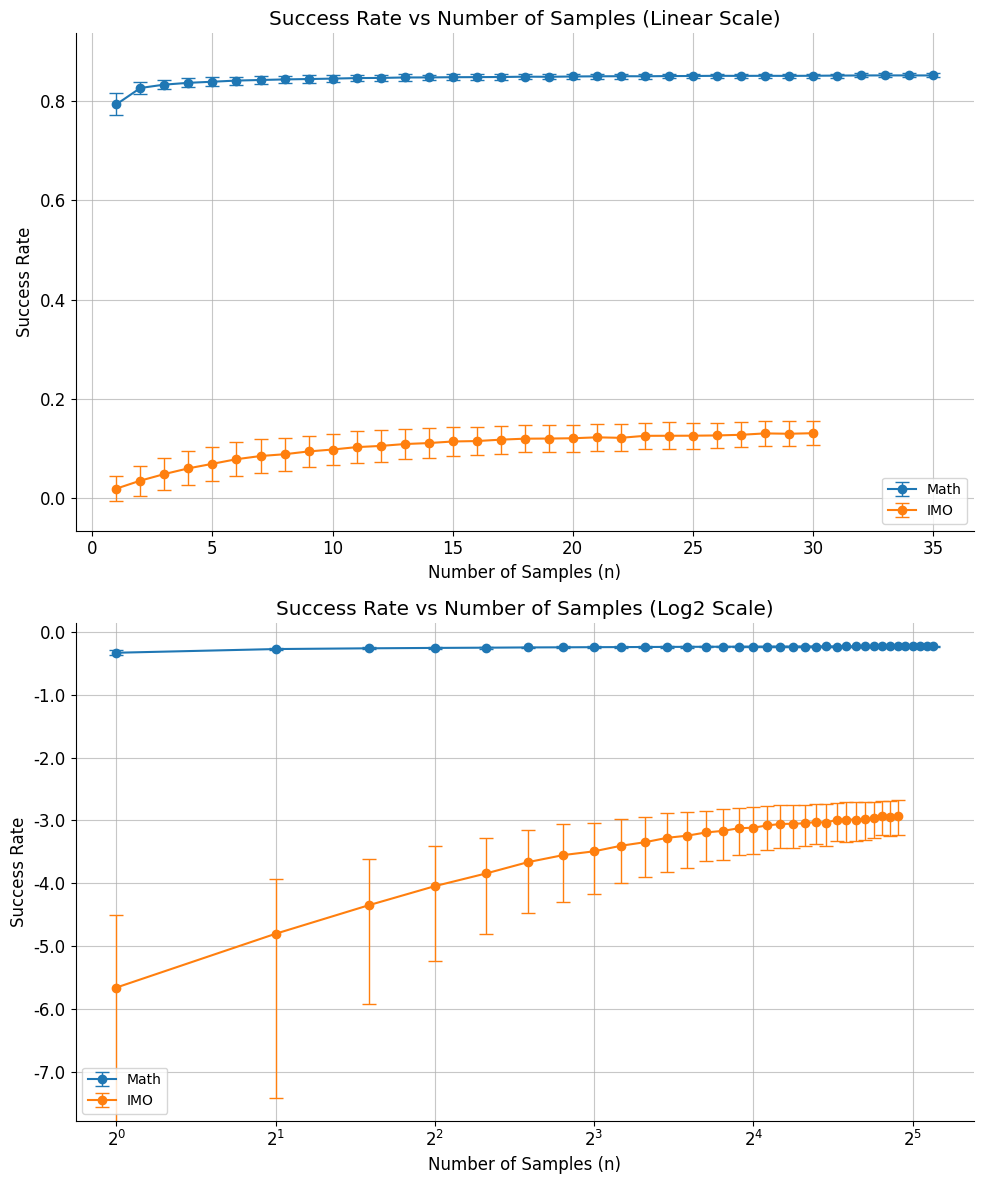

In [27]:
# Extract data for both datasets
x_values_math = [x + 1 for x in list(math_plotting_data.keys())]
means_math = [math_plotting_data[x-1][0] for x in x_values_math]
stds_math = [math_plotting_data[x-1][1] for x in x_values_math]

x_values_imo = [x + 1 for x in list(imo_plotting_data.keys())]
means_imo = [imo_plotting_data[x-1][0] for x in x_values_imo]
stds_imo = [imo_plotting_data[x-1][1] for x in x_values_imo]

# Create subplots (now just 2 instead of 3)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Linear plot
ax1.errorbar(x_values_math, means_math, yerr=stds_math, fmt='-o', capsize=5, capthick=1, elinewidth=1, label='Math')
ax1.errorbar(x_values_imo, means_imo, yerr=stds_imo, fmt='-o', capsize=5, capthick=1, elinewidth=1, label='IMO')
ax1.set_xlabel('Number of Samples (n)')
ax1.set_ylabel('Success Rate')
ax1.set_title('Success Rate vs Number of Samples (Linear Scale)')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(True, linestyle='-', alpha=0.7)
ax1.legend()
ax1.set_ylim(min(min(means_math), min(means_imo)) - max(max(stds_math), max(stds_imo)) - 0.05, 
             max(max(means_math), max(means_imo)) + max(max(stds_math), max(stds_imo)) + 0.05)

# Log-log plot
ax2.errorbar(x_values_math, means_math, yerr=stds_math, fmt='-o', capsize=5, capthick=1, elinewidth=1, label='Math')
ax2.errorbar(x_values_imo, means_imo, yerr=stds_imo, fmt='-o', capsize=5, capthick=1, elinewidth=1, label='IMO')
ax2.set_xscale('log', base=2)
ax2.set_yscale('log', base=2)
ax2.set_xlabel('Number of Samples (n)')
ax2.set_ylabel('Success Rate')
ax2.set_title('Success Rate vs Number of Samples (Log2 Scale)')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(True, linestyle='-', alpha=0.7)
ax2.legend()
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1f}'.format(np.log2(y))))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

# IMO Problems

In [181]:
import pickle 

with open("verified_outputs_imo.pkl", "rb") as f:
    verified_outputs = pickle.load(f)

print(len(verified_outputs))
print(len(verified_outputs[0]))

20
27


In [183]:
passed = np.zeros((len(verified_outputs), len(verified_outputs[0])), dtype=bool)
complete = np.zeros((len(verified_outputs), len(verified_outputs[0])), dtype=bool)

num_repeats = len(verified_outputs[0]) - 1
num_malformed = 0
for i in range(len(verified_outputs)):
    for j in range(num_repeats):
        if verified_outputs[i][j] is None:
            passed[i, j] = False
            complete[i, j] = False
            num_malformed += 1
        else:
            passed[i, j] = verified_outputs[i][j]["pass"]
            complete[i, j] = verified_outputs[i][j]["complete"]


assert np.all(passed == complete), "passed and complete arrays are not equal"

In [184]:
boostrap_success = {}
bootstrap_samples = 1000

for i in range(num_repeats):
    indices = np.random.choice(num_repeats, size=(bootstrap_samples, i+1), replace=True)
    success = np.any(passed[:, indices], axis=2)
    boostrap_success[i] = np.mean(success, axis=0)


plotting_data = {}
for key, value in boostrap_success.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0)
    plotting_data[key] = (mean, std)

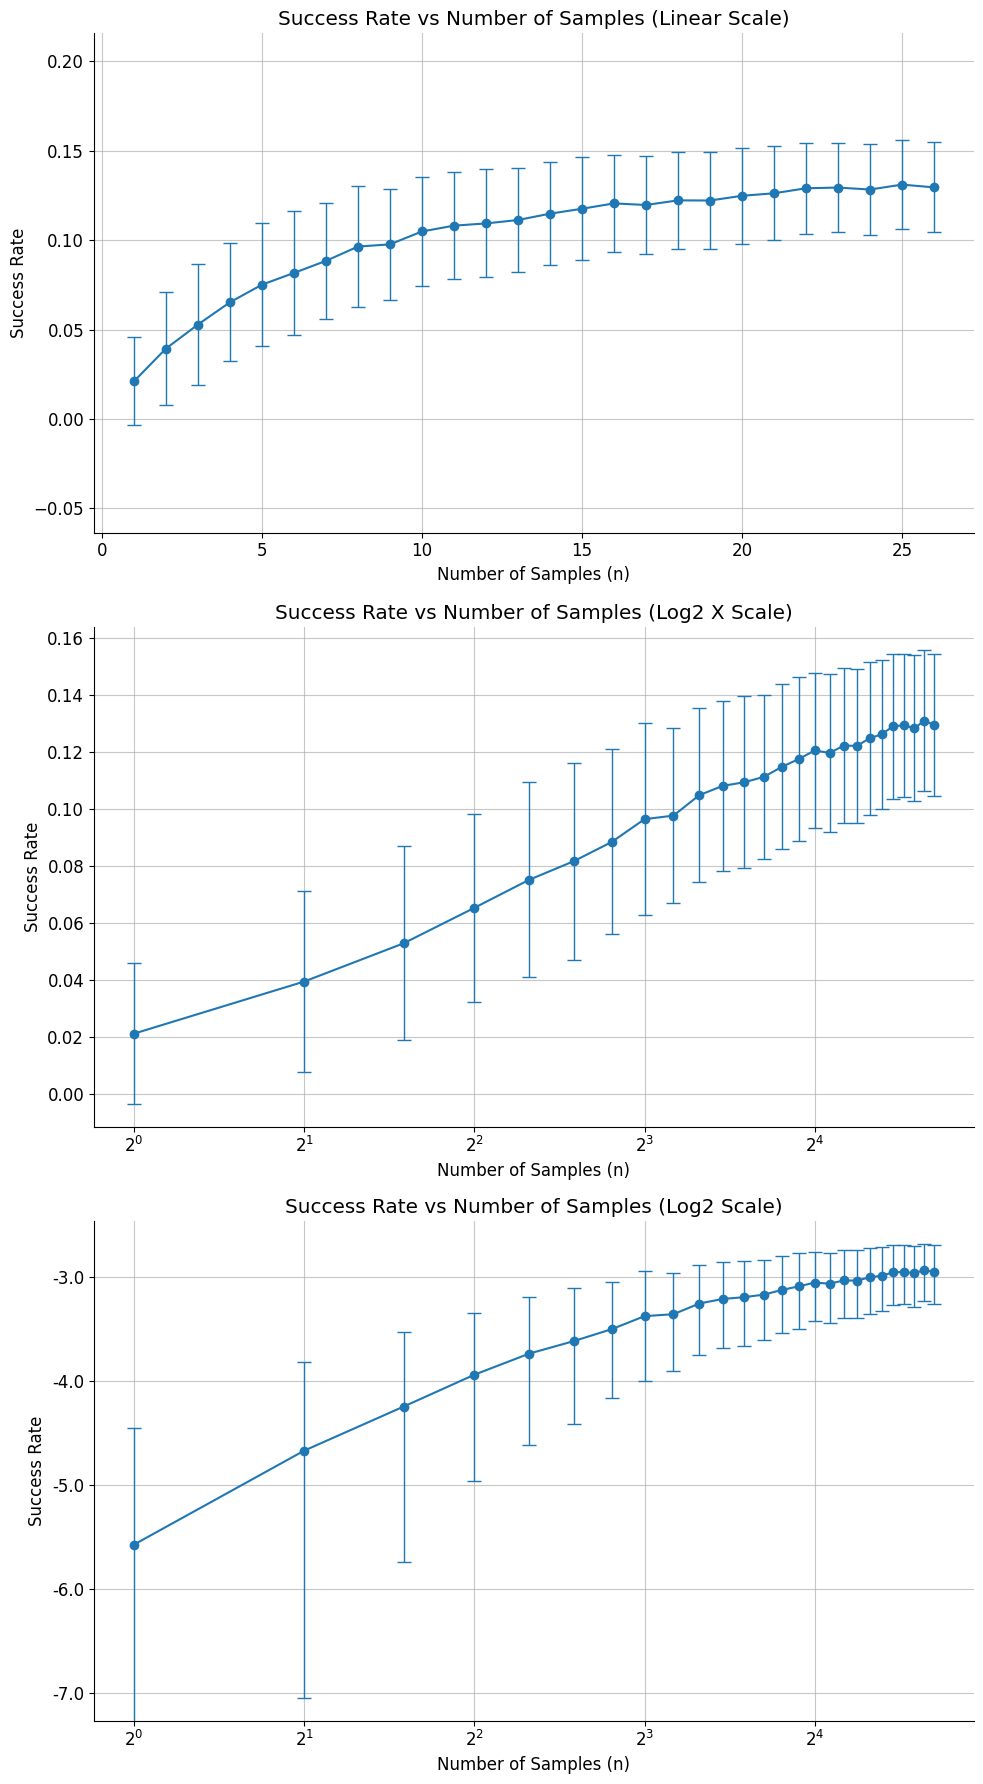

In [185]:
import matplotlib.pyplot as plt

# Extract data
x_values = [x + 1 for x in list(plotting_data.keys())]
means = [plotting_data[x-1][0] for x in x_values]
stds = [plotting_data[x-1][1] for x in x_values]

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 18))

# Linear plot
ax1.errorbar(x_values, means, yerr=stds, fmt='-o', capsize=5, capthick=1, elinewidth=1)
ax1.set_xlabel('Number of Samples (n)')
ax1.set_ylabel('Success Rate')
ax1.set_title('Success Rate vs Number of Samples (Linear Scale)')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(True, linestyle='-', alpha=0.7)
ax1.set_ylim(min(means) - max(stds) - 0.05, max(means) + max(stds) + 0.05)

# Semi-log plot (x-axis log scale only)
ax2.errorbar(x_values, means, yerr=stds, fmt='-o', capsize=5, capthick=1, elinewidth=1)
ax2.set_xscale('log', base=2)
ax2.set_xlabel('Number of Samples (n)')
ax2.set_ylabel('Success Rate')
ax2.set_title('Success Rate vs Number of Samples (Log2 X Scale)')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(True, linestyle='-', alpha=0.7)

# Log-log plot
ax3.errorbar(x_values, means, yerr=stds, fmt='-o', capsize=5, capthick=1, elinewidth=1)
ax3.set_xscale('log', base=2)
ax3.set_yscale('log', base=2)
ax3.set_xlabel('Number of Samples (n)')
ax3.set_ylabel('Success Rate')
ax3.set_title('Success Rate vs Number of Samples (Log2 Scale)')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.grid(True, linestyle='-', alpha=0.7)
# Add y-axis labels
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1f}'.format(np.log2(y))))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()